In [19]:
#import packages for spatial analysis
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import folium

In [20]:
#read in the data
council_districts = gpd.read_file('council_districts.geojson')
council_districts.head()

first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   
2      Nancy    nancy.vanreece@nashville.gov  615-576-0488  615-862-6780   
3       Bill    bill.pridemore@nashville.gov  615-915-1419  615-862-6780   
4     Robert      robert.swope@nashville.gov  615-308-0577  615-862-6780   

   last_name        position district  \
0   Leonardo  Council Member        1   
1   Hastings  Council Member        2   
2   VanReece  Council Member        8   
3  Pridemore  Council Member        9   
4      Swope  Council Member        4   

                                            geometry  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...  
2  MULTIPOLYGON (((-86.7285 36.28328, -86.72791 3...  
3  MULTIPOLYGON (((-86.68681 36.28671, -86.68706 ...  
4  MULTIPOLYGON (((-86.74489 36.05316, -86.74491 ...

In [21]:
council_districts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   first_name  35 non-null     object  
 1   email       35 non-null     object  
 2   res_phone   34 non-null     object  
 3   bus_phone   34 non-null     object  
 4   last_name   35 non-null     object  
 5   position    35 non-null     object  
 6   district    35 non-null     object  
 7   geometry    35 non-null     geometry
dtypes: geometry(1), object(7)
memory usage: 2.3+ KB


In [22]:
#check the crs
council_districts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [23]:
#load the permits data
permits=pd.read_csv('nashville_building_permits_2017.csv')
permits.head()

permit_id      issued      cost        lat        lng
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211

In [24]:
#construct a geometry column
permits['geometry']= gpd.points_from_xy(permits['lng'], permits['lat'])
permits.head()

permit_id      issued      cost        lat        lng  \
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235   
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222   
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892   
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815   
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211   

                     geometry  
0  POINT (-86.74224 36.19824)  
1  POINT (-86.83022 36.15155)  
2  POINT (-86.70889 36.03424)  
3  POINT (-86.84182 36.12866)  
4  POINT (-86.61621 36.04504)

In [25]:
#construct a geodataframe from the permits data
permits_geo=gpd.GeoDataFrame(permits,crs=council_districts.crs ,geometry=permits.geometry)
#check the type of the permits_geo
type(permits_geo)
permits_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
permits_geo.head()

permit_id      issued      cost        lat        lng  \
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235   
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222   
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892   
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815   
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211   

                     geometry  
0  POINT (-86.74224 36.19824)  
1  POINT (-86.83022 36.15155)  
2  POINT (-86.70889 36.03424)  
3  POINT (-86.84182 36.12866)  
4  POINT (-86.61621 36.04504)

In [27]:
#create an area column in the council_districts geodataframe
#first convert the crs to a projected crs that uses meters
council_districts=council_districts.to_crs(epsg=3857)

#create area in square km
council_districts['area_sqkm']=council_districts.area/ 10**6

#change council_districts crs back to the original crs to preserve the geometry in decimal degrees
council_districts=council_districts.to_crs(epsg=4326)

In [28]:
#spatially join the permits_geo and council_districts geodataframes
permits_by_district=gpd.sjoin(permits_geo, council_districts, predicate='within')
permits_by_district.head()

permit_id      issued      cost        lat        lng  \
0  2017032777  2017-05-24  226201.0  36.198241 -86.742235   
1  2017061156  2017-10-23   15000.0  36.151554 -86.830222   
2  2017074521  2017-11-20   13389.0  36.034239 -86.708892   
3  2017035041  2017-05-30   40000.0  36.128659 -86.841815   
4  2017000049  2017-01-09  268107.0  36.045042 -86.616211   

                     geometry  index_right first_name  \
0  POINT (-86.74224 36.19824)            5      Scott   
1  POINT (-86.83022 36.15155)           21   Kathleen   
2  POINT (-86.70889 36.03424)           28     Fabian   
3  POINT (-86.84182 36.12866)           21   Kathleen   
4  POINT (-86.61621 36.04504)           29    Jacobia   

                          email     res_phone     bus_phone last_name  \
0     scott.davis@nashville.gov  615-554-9730  615-862-6780     Davis   
1  kathleen.murphy@nashvlle.gov  615-828-4713  615-862-6780    Murphy   
2    fabian.bedne@nashville.gov  615-829-6226  615-862-6780     Bedne   
3  kathleen.murphy@nashvlle.gov  615-828-4713  615-862-6780    Murphy   
4  jacobia.dowell@nashville.gov  615-731-3177  615-862-6780    Dowell   

         position district  area_sqkm  
0  Council Member        5  19.030612  
1  Council Member       24  21.844122  
2  Council Member       31  52.170070  
3  Council Member       24  21.844122  
4  Council Member       32  29.916169

In [29]:
#count the permits in each district
permit_counts=permits_by_district.groupby('district').size()
permit_counts.sort_values(ascending=False)

district
19    969
20    799
17    786
21    569
7     468
24    458
6     455
5     452
25    435
2     399
33    355
15    322
16    303
22    291
18    287
14    261
11    239
32    225
34    218
3     215
8     209
23    206
35    192
9     186
26    179
12    163
29    154
1     146
13    139
4     139
31    134
10    119
28    119
27    105
30     79
dtype: int64

In [30]:
#convert the series to a dataframe
permit_counts_df=permit_counts.to_frame()
permit_counts_df=permit_counts_df.reset_index()
permit_counts_df.columns=['district','bldg_permits']
permit_counts_df.head()

district  bldg_permits
0        1           146
1       10           119
2       11           239
3       12           163
4       13           139

In [31]:
#merge the permit_counts_df with the permits_by_district geodataframe
districts_and_permits = pd.merge(council_districts, permit_counts_df, on='district')
districts_and_permits.head(2)

first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Council Member        2   

                                            geometry   area_sqkm  bldg_permits  
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851           146  
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987           399

In [32]:
#create permit density column
districts_and_permits['permits_density']=districts_and_permits['bldg_permits']/districts_and_permits['area_sqkm']
districts_and_permits.head(2)

first_name                           email     res_phone     bus_phone  \
0       Nick     nick.leonardo@nashville.gov  615-509-6334  615-862-6780   
1    DeCosta  decosta.hastings@nashville.gov  615-779-1565  615-862-6780   

  last_name        position district  \
0  Leonardo  Council Member        1   
1  Hastings  Council Member        2   

                                            geometry   area_sqkm  \
0  MULTIPOLYGON (((-86.90738 36.39052, -86.90725 ...  350.194851   
1  MULTIPOLYGON (((-86.75902 36.23091, -86.75909 ...   44.956987   

   bldg_permits  permits_density  
0           146         0.416911  
1           399         8.875150

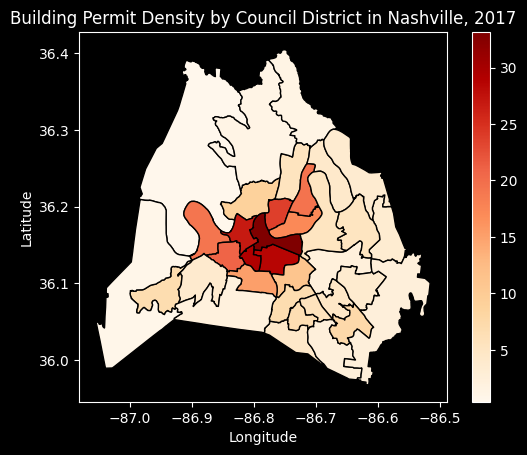

In [33]:
#create a chloropleth map of permit density
districts_and_permits.plot(column='permits_density', cmap='OrRd', edgecolor='black', legend=True)

#add axis labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Building Permit Density by Council District in Nashville, 2017')
plt.show()

In [34]:
#creating a folium choropleth map

# Center point for Nashville
nashville = [36.1636,-86.7823]

# Create map
m = folium.Map(location=nashville, zoom_start=10)

folium.Choropleth(
    geo_data=districts_and_permits,
    name="geometry",
    data=districts_and_permits,
    columns=["district", "permits_density"],
    key_on='feature.properties.district',
    fill_color="Reds",
    fill_opacity=0.5,
    line_opacity=1.0,
    legend_name='2017 Permitted Building Projects per km squared'
).add_to(m)

# Create LayerControl and add it to the map            
folium.LayerControl().add_to(m)

# Display the map
display(m)   

In [35]:
# Create center column for the centroid of each district
districts_and_permits['center'] = districts_and_permits.centroid

C:\Users\mubia\AppData\Local\Temp\ipykernel_7712\2161363797.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  districts_and_permits['center'] = districts_and_permits.centroid


In [36]:
# Build markers and popups to show district number and number of permits issued
for row in districts_and_permits.iterrows():
    row_values = row[1]
    center_point = row_values['center']
    location = [center_point.y, center_point.x]
    district = row_values['district']
    permits = row_values['bldg_permits']
    popup_text = "District: {}<br>Permits: {}".format(district, permits)
    popup = folium.Popup(popup_text, max_width=300)
    marker = folium.Marker(location=location, popup=popup)
    marker.add_to(m)
    
# Display the map
display(m)

In [37]:
#export the map to an html file
m.save('nashville_permits_map.html')

In [38]:
# Display a static image placeholder (optional)
m._repr_html_()  # For inline rendering in a Jupyter Notebook
display(m)